<p align="center"><img src='https://drive.google.com/uc?export=view&id=1Q3X1N08GMDGuKZq_2Kh7ADqYFEdddg17'></p>

# **Analyse exploratroire de données**

# 1 Preliminary

## 1.1 Context

La poule qui chante est une entreprise française d’agroalimentaire qui souhaite se développer à l'international. L'entreprise n'a pas encore identifier aucun pays ni aucun continent particuliers pour son développement. L'objectif de ce travail est de faire une étude de marché en proposant à l’entreprise une première analyse des groupements de pays qu'elle peut cibler pour exporter ses produits.

L'étude se fait en deux parties, la première vise à proposer une première analyse exploratoire de données. La seconde utilise des algorithmes d'apprentissage non supervisé, y compris la classification et le clustering pour segmenter les pays.

Dans ce notebook, nous allons surtout nettoyer les données, sélectionner les variables qui semblent pertinentes, faire une analyse univariée et multivariée et puis appliquer quelques transformations de données si nécessaire.

## 1.2 Libraries

In [1]:
import pandas as pd
import numpy as np
from math import radians

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import haversine_distances

import scipy.stats as st

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.graphics.gofplots import qqplot

## 1.3 Options

In [2]:
# Modifier un parametrage du pandas
pd.options.display.max_columns=999
# Afficher des décimaux sans format scientifique
pd.options.display.float_format = '{:.3f}'.format
# Identifier les valeurs qui seront considérées comme nulles
missing_values = ["n/a", "na", "--","nan","NaN", "NaT", " ", ""]

## 1.4 Functions

In [3]:
# Calculer la distance entre paris et une destination
def distance_from_paris(latitude, longitude):
  paris = [49.0083899664, 2.53844117956]
  distination = [latitude, longitude]
  distination_in_radians = [radians(x) for x in distination]
  paris_in_radians = [radians(y) for y in paris]
  result = haversine_distances([distination_in_radians, paris_in_radians])
  result *= 6371000/1000  # multiplier par le rayon de la Terre pour obtenir des kilomètres
  return result[0][1]

In [4]:
# Détecter et lister les outliers d'un dataframe
def outliers_decector(df):
  outliers = {}
  outliers_list = []
  indexes_list = []
  variables_list = []
  
  for col in df.columns:
    var_outliers = {}
    
    q1 = df[col].quantile(0.25) # Calculer le premier quartile Q1
    q3 = df[col].quantile(0.75) # Calculer le troisième quartile Q3
    iqr = q3 - q1 # Calculer l'écart interquartile IQR
    
    var_out = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col]> (q3 + 1.5 * iqr))].index.to_list()
    
    if len(var_out) > 0:
      variables_list.append(col)
      var_outliers['var_name'] = col
      var_outliers['n_outliers'] = len(var_out)
      var_outliers['outliers'] = var_out
      outliers_list.append(var_outliers)   
      for e in var_out:
        if e not in indexes_list:
          indexes_list.append(e)

  outliers['n_outliers'] = len(indexes_list)
  outliers['indexes'] = indexes_list
  outliers['n_variables'] = len(variables_list)
  outliers['variables'] = variables_list
  outliers['list'] = outliers_list

  return outliers

In [5]:
# Tester graphiquement la distribution des varaibles d'un DataFrame
def normality_graphical_test(df):
  for col in df.columns:
    fig, axes = plt.subplots(1, 3, figsize = (8, 2))
    df[col].plot(kind='hist', ax = axes[0]);
    df[col].plot(kind='kde', ax = axes[1]);
    axes[0].set_title(col)
    axes[1].set_title(col)
    
    qqplot(df[col], line='s', ax = axes[2])
    plt.title(col)
    fig.tight_layout()
    plt.show()

In [6]:
# Tourner le test de normalité de D’Agostino et Pearson
def dagostino_test(df, alpha):
  print(f"Test de D’Agostino et Pearson (alpha = {alpha}) \n")
  for col in df.columns:
    s2k2, p = st.normaltest(df[col])
    print(f'Variable : {col}')
    print(f'Résultat : S2 + K2 = {round(s2k2, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interprétation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interprétation : la distribution semble anormale (non gaussienne) \n')

In [7]:
# Tourner le test de normalité de Shapiro-Wilk
def shapiro_test(df, alpha):
  print(f"Test de Shapiro-Wilk (alpha = {alpha}) \n")
  for col in df.columns:
    w, p = st.shapiro(df[col])
    print(f'Variable : {col}')
    print(f'Résultat : w = {round(w, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interprétation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interprétation : la distribution semble anormale (non gaussienne) \n')

# 2 Data Preparation

## 2.1 Data Loading

In [8]:
# Indicateur de disponibilité alimentaire
food_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/DisponibiliteAlimentaire_2017.csv", na_values = missing_values)

# Indicateur politique, Source : https://www.fao.org/faostat/fr/#data/FS
politic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/FAOSTAT_POLI.csv", na_values = missing_values)

# Indicateur macroéconomique, source : https://www.fao.org/faostat/fr/#data/MK
economic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/FAOSTAT_MACRO.csv", na_values = missing_values)

# Indicateur démographique, source : https://www.fao.org/faostat/fr/#data/MK
population_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/Population_2000_2018.csv", na_values = missing_values)

# Indicateur géographique, Source : FAO + Google sheet Extension (Geoencoding by Awesome)
geocode_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/countries_geocoding.csv", na_values = missing_values)


## 2.2 Data Overview

In [9]:
food_df.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.000,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.000,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.000,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.000,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.000,S,Données standardisées


In [10]:
food_df.tail()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
176595,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2899,Miscellanees,2017,2017,Milliers de tonnes,19.000,S,Données standardisées
176596,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/pers...,2899,Miscellanees,2017,2017,kg,1.330,Fc,Donnée calculée
176597,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2899,Miscellanees,2017,2017,Kcal/personne/jour,1.000,Fc,Donnée calculée
176598,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/pers...,2899,Miscellanees,2017,2017,g/personne/jour,0.040,Fc,Donnée calculée
176599,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,684,Disponibilité de matière grasse en quantité (g...,2899,Miscellanees,2017,2017,g/personne/jour,0.020,Fc,Donnée calculée


In [11]:
food_df.shape

(176600, 14)

In [12]:
food_df.columns

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole'],
      dtype='object')

In [13]:
food_df.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

## 2.3 Data Cleaning

In [14]:
data = food_df.copy()

**Disponibilité alimentaire**

In [15]:
data.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole       2
dtype: int64

In [16]:
data['Produit'].unique()

array(['Blé et produits', 'Riz et produits', 'Orge et produits',
       'Maïs et produits', 'Seigle et produits', 'Avoine',
       'Millet et produits', 'Sorgho et produits', 'Céréales, Autres',
       'Pommes de Terre et produits', 'Ignames', 'Racines nda',
       'Sucre, canne', 'Sucre, betterave', 'Sucre Eq Brut',
       'Edulcorants Autres', 'Miel', 'Haricots', 'Pois',
       'Légumineuses Autres et produits', 'Noix et produits', 'Soja',
       'Arachides Decortiquees', 'Graines de tournesol',
       'Graines Colza/Moutarde', 'Graines de coton', 'Coco (Incl Coprah)',
       'Sésame', 'Olives', 'Plantes Oleiferes, Autre', 'Huile de Soja',
       "Huile d'Arachide", 'Huile de Tournesol',
       'Huile de Colza&Moutarde', 'Huile Graines de Coton',
       'Huile de Palmistes', 'Huile de Palme', 'Huile de Coco',
       'Huile de Sésame', "Huile d'Olive", 'Huile de Son de Riz',
       'Huile de Germe de Maïs', 'Huil Plantes Oleif Autr',
       'Tomates et produits', 'Oignons', 'Légumes, 

Séléctionner la disponibilité de la viande de volailles

In [17]:
data.query("Produit == 'Viande de Volailles'", inplace=True)

In [18]:
data['Élément'].unique()

array(['Production', 'Importations - Quantité', 'Variation de stock',
       'Disponibilité intérieure', 'Pertes', 'Résidus', 'Nourriture',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Exportations - Quantité', 'Alimentation pour touristes',
       'Traitement', 'Autres utilisations (non alimentaire)',
       'Aliments pour animaux', 'Semences'], dtype=object)

On va séléctionner les éléments suivants qui semblent les plus pertinents : 
- Production
- Importations - Quantité
- Exportations - Quantité
- Disponibilité intérieure
- Pertes
- Nourriture
- Disponibilité alimentaire en quantité (kg/personne/an)


In [19]:
elements = ['Production', 'Importations - Quantité', 'Exportations - Quantité', 'Disponibilité intérieure', 'Pertes', 
        'Nourriture', 'Disponibilité alimentaire en quantité (kg/personne/an)']
data = data[data['Élément'].isin(elements)]

Ensuite, on supprime les colonnes non pertinentes

In [20]:
data.columns

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole'],
      dtype='object')

In [21]:
cols = ['Zone', 'Élément', 'Valeur']
data = data[cols].copy()

In [22]:
data.shape

(1052, 3)

In [23]:
data.dtypes

Zone        object
Élément     object
Valeur     float64
dtype: object

Vérifions s'il y a des doublons

In [24]:
data.duplicated(subset=['Zone', 'Élément']).sum()

0

In [25]:
data = pd.pivot_table(data, values='Valeur', index=['Zone'], columns=['Élément'], fill_value=0)
data.head()

Élément,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production
Zone,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28
Afrique du Sud,35.690,2118,63,514,2035,83,1667
Albanie,16.360,47,0,38,47,0,13
Algérie,6.380,277,0,2,264,13,275
Allemagne,19.470,1739,646,842,1609,0,1514


À noter, Il y a une relation entre les variables qui peut s’exprimer avec l'équation suivante : disponibilité intérieure = production + importations - exportations +- variation de stock = nourriture + aliment pour animaux + autre utilisation + pertes + semences + traitement

In [26]:
data.shape

(172, 7)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 7 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Disponibilité alimentaire en quantité (kg/personne/an)  172 non-null    float64
 1   Disponibilité intérieure                                172 non-null    int64  
 2   Exportations - Quantité                                 172 non-null    int64  
 3   Importations - Quantité                                 172 non-null    int64  
 4   Nourriture                                              172 non-null    int64  
 5   Pertes                                                  172 non-null    int64  
 6   Production                                              172 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 10.8+ KB


Renommer les colonnes 

In [28]:
data.rename(columns={'Disponibilité alimentaire en quantité (kg/personne/an)': 'disponibilité_alimentaire',
                        'Disponibilité intérieure': 'disponibilité_intérieure',
                        'Importations - Quantité': 'importations', 
                        'Exportations - Quantité': 'exportations', 
                        'Nourriture': 'nourriture', 
                        'Pertes': 'pertes', 
                        'Production': 'production'}, 
               inplace=True)

In [29]:
data.head()

Élément,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production
Zone,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28
Afrique du Sud,35.690,2118,63,514,2035,83,1667
Albanie,16.360,47,0,38,47,0,13
Algérie,6.380,277,0,2,264,13,275
Allemagne,19.470,1739,646,842,1609,0,1514


Vérifions s'il y a des valeurs manquantes

In [30]:
data.isna().sum()

Élément
disponibilité_alimentaire    0
disponibilité_intérieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
dtype: int64

Calcul de la disponibilité alimentaire en protéines et en calories par pays par personne, touts éléments confondus

In [31]:
food_df.shape

(176600, 14)

In [32]:
df = food_df.groupby(by=['Zone', 'Élément'])['Valeur'].sum().reset_index()
df.head()

,Zone,Élément,Valeur
0,Afghanistan,Aliments pour animaux,456.000
1,Afghanistan,Autres utilisations (non alimentaire),94.000
2,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),1997.000
3,Afghanistan,Disponibilité alimentaire en quantité (kg/pers...,357.310
4,Afghanistan,Disponibilité de matière grasse en quantité (g...,30.630


In [33]:
df = df[df['Élément'].isin(['Disponibilité alimentaire (Kcal/personne/jour)', 'Disponibilité de protéines en quantité (g/personne/jour)', ])]
df.head()

,Zone,Élément,Valeur
2,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),1997.000
5,Afghanistan,Disponibilité de protéines en quantité (g/pers...,54.090
19,Afrique du Sud,Disponibilité alimentaire (Kcal/personne/jour),2987.000
22,Afrique du Sud,Disponibilité de protéines en quantité (g/pers...,83.360
35,Albanie,Disponibilité alimentaire (Kcal/personne/jour),3400.000


In [34]:
df = pd.pivot_table(df, values='Valeur', index=['Zone'], columns=['Élément'], fill_value=0)
df.head()

Élément,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
Zone,,
Afghanistan,1997,54.090
Afrique du Sud,2987,83.360
Albanie,3400,119.500
Algérie,3345,92.850
Allemagne,3559,104.070


In [35]:
df.shape

(172, 2)

In [36]:
df.rename(columns={'Disponibilité alimentaire (Kcal/personne/jour)': 'disponibilité_calories', 
                   'Disponibilité de protéines en quantité (g/personne/jour)': 'disponibilité_proteines'},
           inplace=True)

In [37]:
data = pd.merge(data, df, on='Zone')
data.head()

Élément,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines
Zone,,,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28,1997,54.090
Afrique du Sud,35.690,2118,63,514,2035,83,1667,2987,83.360
Albanie,16.360,47,0,38,47,0,13,3400,119.500
Algérie,6.380,277,0,2,264,13,275,3345,92.850
Allemagne,19.470,1739,646,842,1609,0,1514,3559,104.070


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disponibilité_alimentaire  172 non-null    float64
 1   disponibilité_intérieure   172 non-null    int64  
 2   exportations               172 non-null    int64  
 3   importations               172 non-null    int64  
 4   nourriture                 172 non-null    int64  
 5   pertes                     172 non-null    int64  
 6   production                 172 non-null    int64  
 7   disponibilité_calories     172 non-null    int64  
 8   disponibilité_proteines    172 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 13.4+ KB


**Stabilité politique**

In [39]:
politic_df.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,4,Afghanistan,6121,Valeur,21010,Suffisance des apports énergétiques alimentair...,20162018,2016-2018,%,106,E,Valeur estimée,NaN
1,FS,Données de la sécurité alimentaire,4,Afghanistan,6128,Valeur,22000,Disponibilité alimentaire par habitant utilisé...,20162018,2016-2018,Kcal/personne/jour,2266,E,Valeur estimée,NaN
2,FS,Données de la sécurité alimentaire,4,Afghanistan,6121,Valeur,21012,"Part des céréales, des racines et des tubercul...",20162018,2016-2018,%,71,E,Valeur estimée,NaN
3,FS,Données de la sécurité alimentaire,4,Afghanistan,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,58,E,Valeur estimée,NaN
4,FS,Données de la sécurité alimentaire,4,Afghanistan,6123,Valeur,21014,Disponibilités protéines moyennes d’origine an...,20162018,2016-2018,g/personne/jour,10.7,E,Valeur estimée,NaN


In [40]:
politic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8273 entries, 0 to 8272
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Code Domaine            8273 non-null   object
 1   Domaine                 8273 non-null   object
 2   Code zone (M49)         8273 non-null   int64 
 3   Zone                    8273 non-null   object
 4   Code Élément            8273 non-null   int64 
 5   Élément                 8273 non-null   object
 6   Code Produit            8273 non-null   object
 7   Produit                 8273 non-null   object
 8   Code année              8273 non-null   int64 
 9   Année                   8273 non-null   object
 10  Unité                   8273 non-null   object
 11  Valeur                  6469 non-null   object
 12  Symbole                 8092 non-null   object
 13  Description du Symbole  8092 non-null   object
 14  Note                    176 non-null    object
dtypes: i

Ce qui nous intéresse ici, c'est la valeur de l'indice de la stabilité politique, on va la séléctionner 

In [41]:
df = politic_df[(politic_df['Code Élément'] == 6125) & (politic_df['Code Produit'] == '21032')].copy()
df.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
23,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-2.8,X,Ciffre de sources internationales,NaN
65,FS,Données de la sécurité alimentaire,710,Afrique du Sud,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-0.28,X,Ciffre de sources internationales,NaN
107,FS,Données de la sécurité alimentaire,8,Albanie,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.38,X,Ciffre de sources internationales,NaN
152,FS,Données de la sécurité alimentaire,12,Algérie,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,-0.92,X,Ciffre de sources internationales,NaN
195,FS,Données de la sécurité alimentaire,276,Allemagne,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.59,X,Ciffre de sources internationales,NaN


In [42]:
df.shape

(197, 15)

In [43]:
cols = ['Zone', 'Valeur']
df = df[cols].copy()

In [44]:
df.head()

,Zone,Valeur
23,Afghanistan,-2.8
65,Afrique du Sud,-0.28
107,Albanie,0.38
152,Algérie,-0.92
195,Allemagne,0.59


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 23 to 8254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Zone    197 non-null    object
 1   Valeur  197 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [46]:
df['Valeur'] = df.Valeur.astype('float')

In [47]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [48]:
df.set_index('Zone', inplace=True)

In [49]:
df.rename(columns={'Valeur': 'stabilité_politique'}, inplace=True)

In [50]:
df.head()

,stabilité_politique
Zone,
Afghanistan,-2.800
Afrique du Sud,-0.280
Albanie,0.380
Algérie,-0.920
Allemagne,0.590


Avant la fusion, vérifions s'il y a des pays qui existent dans le tableau principal (data) mais ils ne trouvent pas dans ce nouveau tableau de stabilité politique.

In [51]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

['Chine, continentale', 'Nouvelle-Calédonie', 'Polynésie française']

In [52]:
data = data.join(df)
data.head()

,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines,stabilité_politique
Zone,,,,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28,1997,54.090,-2.800
Afrique du Sud,35.690,2118,63,514,2035,83,1667,2987,83.360,-0.280
Albanie,16.360,47,0,38,47,0,13,3400,119.500,0.380
Algérie,6.380,277,0,2,264,13,275,3345,92.850,-0.920
Allemagne,19.470,1739,646,842,1609,0,1514,3559,104.070,0.590


Imputation des données manquantes

In [53]:
data.isna().sum()

disponibilité_alimentaire    0
disponibilité_intérieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
disponibilité_calories       0
disponibilité_proteines      0
stabilité_politique          3
dtype: int64

In [54]:
data['stabilité_politique']['Chine, continentale'] = -0.23 # Chiffre de sources internationales (FAO-EN)
data['stabilité_politique']['Nouvelle-Calédonie'] = data['stabilité_politique']['France']
data['stabilité_politique']['Polynésie française'] = data['stabilité_politique']['France']

<ipython-input-54-746cbca3da59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stabilité_politique']['Chine, continentale'] = -0.23 # Chiffre de sources internationales (FAO-EN)
<ipython-input-54-746cbca3da59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stabilité_politique']['Nouvelle-Calédonie'] = data['stabilité_politique']['France']
<ipython-input-54-746cbca3da59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [55]:
data.loc[data.index.isin(decalage), ['stabilité_politique']]

,stabilité_politique
Zone,
"Chine, continentale",-0.230
Nouvelle-Calédonie,0.280
Polynésie française,0.280


**Puissance économique**

In [56]:
economic_df.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,4,Afghanistan,6109,Valeur en devise locale,22008,Produit Intérieur Brut,2017,2017,millions,1285460.326,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,4,Afghanistan,6110,Valeur US $,22008,Produit Intérieur Brut,2017,2017,millions,18896.352,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,520.616,X,Ciffre de sources internationales,NaN
3,MK,Indicateurs macro,4,Afghanistan,6183,"Valeur en devise locale, aux prix de 2015",22008,Produit Intérieur Brut,2017,2017,millions,1192655.490,X,Ciffre de sources internationales,NaN
4,MK,Indicateurs macro,4,Afghanistan,6185,"Valeur US $ par habitant, aux prix du 2015",22008,Produit Intérieur Brut,2017,2017,US$,537.000,X,Ciffre de sources internationales,NaN


Ce qui nous intéresse c'est la valeur du PIB par habitant, on va la sélectionner

In [57]:
df = economic_df[(economic_df['Code Élément'] == 6119) & (economic_df['Code Produit'] == 22008)].copy()
df.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
2,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,520.616,X,Ciffre de sources internationales,NaN
58,MK,Indicateurs macro,710,Afrique du Sud,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,6121.877,X,Ciffre de sources internationales,NaN
138,MK,Indicateurs macro,8,Albanie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4514.205,X,Ciffre de sources internationales,NaN
222,MK,Indicateurs macro,12,Algérie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4109.696,X,Ciffre de sources internationales,NaN
278,MK,Indicateurs macro,276,Allemagne,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,44651.829,X,Ciffre de sources internationales,NaN


In [58]:
df.shape

(211, 15)

In [59]:
cols = ['Zone', 'Valeur']
df = df[cols].copy()

In [60]:
df.head()

,Zone,Valeur
2,Afghanistan,520.616
58,Afrique du Sud,6121.877
138,Albanie,4514.205
222,Algérie,4109.696
278,Allemagne,44651.829


In [61]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [62]:
df.set_index('Zone', inplace=True)

In [63]:
df.rename(columns={'Valeur': 'pibph'}, inplace=True)

In [64]:
df.head()

,pibph
Zone,
Afghanistan,520.616
Afrique du Sud,6121.877
Albanie,4514.205
Algérie,4109.696
Allemagne,44651.829


In [65]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

['Chine, Taiwan Province de']

In [66]:
data = data.join(df)
data.head()

,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines,stabilité_politique,pibph
Zone,,,,,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28,1997,54.090,-2.800,520.616
Afrique du Sud,35.690,2118,63,514,2035,83,1667,2987,83.360,-0.280,6121.877
Albanie,16.360,47,0,38,47,0,13,3400,119.500,0.380,4514.205
Algérie,6.380,277,0,2,264,13,275,3345,92.850,-0.920,4109.696
Allemagne,19.470,1739,646,842,1609,0,1514,3559,104.070,0.590,44651.829


In [67]:
data.isna().sum()

disponibilité_alimentaire    0
disponibilité_intérieure     0
exportations                 0
importations                 0
nourriture                   0
pertes                       0
production                   0
disponibilité_calories       0
disponibilité_proteines      0
stabilité_politique          0
pibph                        1
dtype: int64

In [68]:
data['pibph']['Chine, Taiwan Province de'] = 25061.624 # Chiffre de sources internationales (FMI) de 2017

<ipython-input-68-195d5346ac2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pibph']['Chine, Taiwan Province de'] = 25061.624 # Chiffre de sources internationales (FMI) de 2017


In [69]:
data.loc[data.index.isin(decalage), ['pibph']]

,pibph
Zone,
"Chine, Taiwan Province de",25061.624


**Population**

In [70]:
population_df.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [71]:
population_df.shape

(4411, 15)

In [72]:
df = population_df.loc[population_df['Année'] == 2017, ['Zone', 'Valeur']]
df.head()

,Zone,Valeur
17,Afghanistan,36296.113
36,Afrique du Sud,57009.756
55,Albanie,2884.169
74,Algérie,41389.189
93,Allemagne,82658.409


In [73]:
df.dtypes

Zone       object
Valeur    float64
dtype: object

In [74]:
df['Valeur'] = df['Valeur'] * 1000

In [75]:
df['Valeur'] = df['Valeur'].astype('int')

In [76]:
df.dtypes

Zone      object
Valeur     int64
dtype: object

In [77]:
df.set_index('Zone', inplace=True)

In [78]:
df.rename(columns={'Valeur': 'population'}, inplace=True)

In [79]:
df.head()

,population
Zone,
Afghanistan,36296113
Afrique du Sud,57009756
Albanie,2884169
Algérie,41389189
Allemagne,82658409


In [80]:
decalage = data[~data.index.isin(df.index)].index.to_list()
decalage

[]

In [81]:
data = data.join(df)
data.head()

,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines,stabilité_politique,pibph,population
Zone,,,,,,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28,1997,54.090,-2.800,520.616,36296113
Afrique du Sud,35.690,2118,63,514,2035,83,1667,2987,83.360,-0.280,6121.877,57009756
Albanie,16.360,47,0,38,47,0,13,3400,119.500,0.380,4514.205,2884169
Algérie,6.380,277,0,2,264,13,275,3345,92.850,-0.920,4109.696,41389189
Allemagne,19.470,1739,646,842,1609,0,1514,3559,104.070,0.590,44651.829,82658409


**Coordonnées géographiques**

In [82]:
geocode_df.head()

,Zone,Latitude,Longitude
0,Afghanistan,33.939,67.710
1,Afrique du Sud,-30.559,22.938
2,Albanie,41.153,20.168
3,Algérie,28.034,1.660
4,Allemagne,51.166,10.452


In [83]:
geocode_df.shape

(172, 3)

In [84]:
df = geocode_df.copy()

In [85]:
df.head()

,Zone,Latitude,Longitude
0,Afghanistan,33.939,67.710
1,Afrique du Sud,-30.559,22.938
2,Albanie,41.153,20.168
3,Algérie,28.034,1.660
4,Allemagne,51.166,10.452


In [86]:
df.dtypes

Zone          object
Latitude     float64
Longitude    float64
dtype: object

Calcul de la distance entre une destination et la France (Paris)

In [87]:
df['distance'] = df.apply(lambda x : distance_from_paris(x.Latitude, x.Longitude), axis = 1)

In [88]:
df.set_index('Zone', inplace=True)

In [89]:
df.head()

,Latitude,Longitude,distance
Zone,,,
Afghanistan,33.939,67.710,5500.141
Afrique du Sud,-30.559,22.938,9076.306
Albanie,41.153,20.168,1630.739
Algérie,28.034,1.660,2333.470
Allemagne,51.166,10.452,613.005


In [90]:
data = data.join(df['distance'])
data.head()

,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines,stabilité_politique,pibph,population,distance
Zone,,,,,,,,,,,,,
Afghanistan,1.530,57,0,29,55,2,28,1997,54.090,-2.800,520.616,36296113,5500.141
Afrique du Sud,35.690,2118,63,514,2035,83,1667,2987,83.360,-0.280,6121.877,57009756,9076.306
Albanie,16.360,47,0,38,47,0,13,3400,119.500,0.380,4514.205,2884169,1630.739
Algérie,6.380,277,0,2,264,13,275,3345,92.850,-0.920,4109.696,41389189,2333.470
Allemagne,19.470,1739,646,842,1609,0,1514,3559,104.070,0.590,44651.829,82658409,613.005


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   disponibilité_alimentaire  172 non-null    float64
 1   disponibilité_intérieure   172 non-null    int64  
 2   exportations               172 non-null    int64  
 3   importations               172 non-null    int64  
 4   nourriture                 172 non-null    int64  
 5   pertes                     172 non-null    int64  
 6   production                 172 non-null    int64  
 7   disponibilité_calories     172 non-null    int64  
 8   disponibilité_proteines    172 non-null    float64
 9   stabilité_politique        172 non-null    float64
 10  pibph                      172 non-null    float64
 11  population                 172 non-null    int64  
 12  distance                   172 non-null    float64
dtypes: float64(5), int64(8)
memory usage

## 2.4 Data Insights

Top Chicken Meat Producers

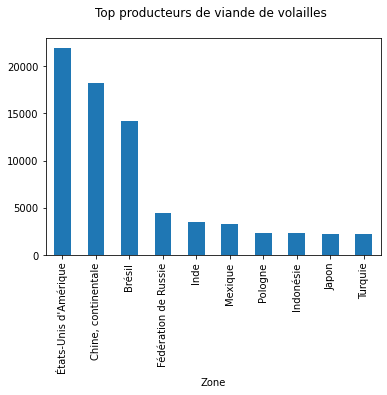

In [92]:
data['production'].sort_values(ascending=False) \
                  .head(10) \
                  .plot(kind='bar', title='Top producteurs de viande de volailles \n');

Top Chicken Meat Importers

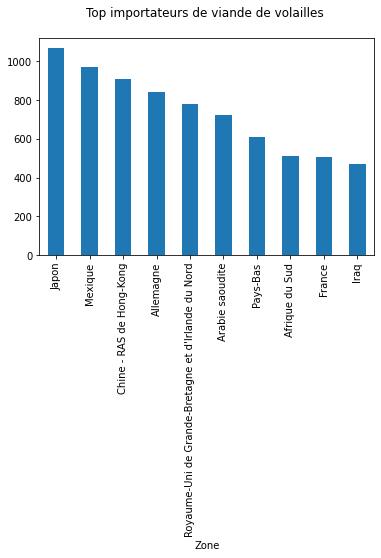

In [93]:
data['importations'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top importateurs de viande de volailles \n');

Top Chicken Meat Exporters

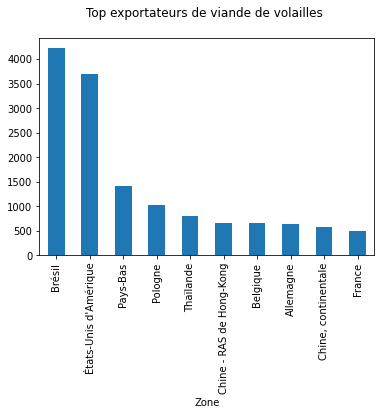

In [94]:
data['exportations'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top exportateurs de viande de volailles \n');

Top GDP per capita

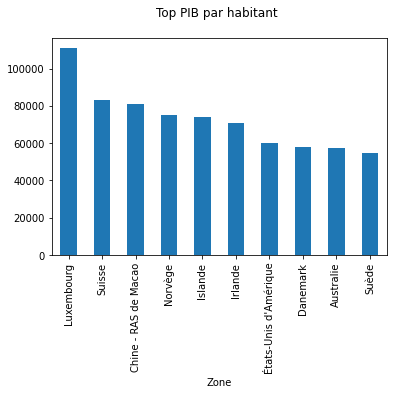

In [95]:
data['pibph'].sort_values(ascending=False) \
                    .head(10) \
                    .plot(kind='bar', title='Top PIB par habitant \n');

# 3 Data Analysis

## 3.1 Univariate Analysis

In [96]:
data.describe()

,disponibilité_alimentaire,disponibilité_intérieure,exportations,importations,nourriture,pertes,production,disponibilité_calories,disponibilité_proteines,stabilité_politique,pibph,population,distance
count,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000,172.000
mean,20.213,679.599,103.750,88.488,649.407,16.977,708.326,2858.395,81.193,-0.061,14108.237,42841754.645,6047.144
std,15.860,2175.613,458.066,185.825,2125.189,78.028,2474.456,454.544,20.199,0.894,19367.569,153063712.477,3871.626
min,0.130,0.000,0.000,0.000,0.000,0.000,0.000,1754.000,39.910,-2.940,450.901,52045.000,216.560
25%,6.440,28.750,0.000,3.000,27.500,0.000,11.000,2514.250,64.213,-0.623,2009.670,2874480.250,3145.744
50%,18.090,98.000,0.000,16.000,94.500,0.000,66.000,2871.500,81.390,0.015,6111.504,9757833.000,5633.585
75%,30.038,360.750,12.000,79.750,353.750,2.000,368.750,3250.250,96.445,0.650,16943.173,30138736.000,8654.400
max,72.310,18266.000,4223.000,1069.000,18100.000,695.000,21914.000,3770.000,141.340,1.600,111017.182,1421021791.000,18932.170


On remarque quelques choses intéressantes par rapport aux variables exportations et pertes. Leur deuxième quartile Q2 (médiane) est 0. Autrement dit, au moins, la moitié des valeurs sont 0. On va les regarder de plus près

La variable Exportations

In [97]:
data.exportations.value_counts().head(10)

0      89
1      11
4       7
2       4
10      3
6       3
3       3
115     2
23      2
44      2
Name: exportations, dtype: int64

La variable exportation contient 89 valeurs nulles. L'enlever pourrait être un choix. On va essayer cependant de récupérer même une petite pièce d'information. Ce qui nous intéresse surtout est de savoir si le pays est un pays exportateur ou pas. On va créer un nouvelle variable binaire ayant la valeur 1 si le pays est un pays exportateur et 0 sinon.

In [98]:
data['exportateur'] = np.where(data['exportations'] == 0, 0, 1)

In [99]:
data.exportateur.value_counts()

0    89
1    83
Name: exportateur, dtype: int64

In [100]:
data.drop(columns=['exportations'], inplace=True)

In [101]:
data.pertes.value_counts().head(10)

0      116
1       10
2        7
3        5
10       3
4        3
5        2
27       2
62       1
161      1
Name: pertes, dtype: int64

La variable pertes contient 116 valeurs nulles, autrement dit, 67% des valeurs sont 0. Elle n'apporte pas beaucoup d'informations. On va la supprimer.

In [102]:
data.drop(columns=['pertes'], inplace=True)

In [103]:
data.columns

Index(['disponibilité_alimentaire', 'disponibilité_intérieure', 'importations',
       'nourriture', 'production', 'disponibilité_calories',
       'disponibilité_proteines', 'stabilité_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

**Outliers Check**

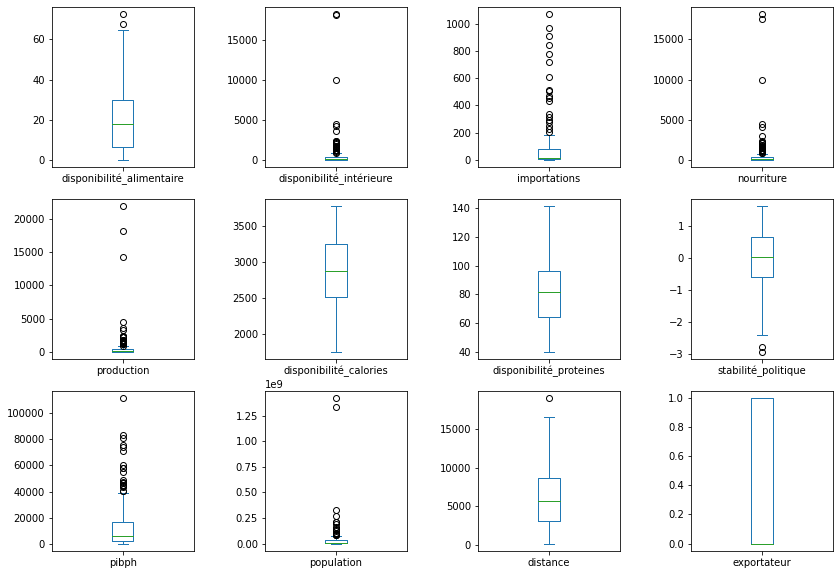

In [104]:
data.plot(kind='box', subplots=True, layout=(3, 4), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [105]:
outliers = outliers_decector(data)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")

Il y a 57 outliers au total
Il y a 9 variables ayant des outliers


In [106]:
outliers['variables']

['disponibilité_alimentaire',
 'disponibilité_intérieure',
 'importations',
 'nourriture',
 'production',
 'stabilité_politique',
 'pibph',
 'population',
 'distance']

In [107]:
outliers['indexes']

['Israël',
 'Saint-Vincent-et-les Grenadines',
 'Afrique du Sud',
 'Allemagne',
 'Arabie saoudite',
 'Argentine',
 'Australie',
 'Brésil',
 'Canada',
 'Chine, continentale',
 'Colombie',
 'Espagne',
 'France',
 'Fédération de Russie',
 'Inde',
 'Indonésie',
 "Iran (République islamique d')",
 'Italie',
 'Japon',
 'Malaisie',
 'Mexique',
 'Myanmar',
 'Pakistan',
 'Philippines',
 'Pologne',
 'Pérou',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
 'Thaïlande',
 'Turquie',
 'Ukraine',
 'Viet Nam',
 'Égypte',
 "États-Unis d'Amérique",
 'Angola',
 'Belgique',
 'Chine - RAS de Hong-Kong',
 'Cuba',
 'Iraq',
 'Pays-Bas',
 'Émirats arabes unis',
 'République de Corée',
 'Afghanistan',
 'Yémen',
 'Autriche',
 'Chine - RAS de Macao',
 'Danemark',
 'Finlande',
 'Irlande',
 'Islande',
 'Luxembourg',
 'Norvège',
 'Nouvelle-Zélande',
 'Suisse',
 'Suède',
 'Bangladesh',
 'Nigéria',
 'Éthiopie']

In [108]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable disponibilité_alimentaire contient 2 outlier(s)
['Israël', 'Saint-Vincent-et-les Grenadines'] 

La variable disponibilité_intérieure contient 31 outlier(s)
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Brésil', 'Canada', 'Chine, continentale', 'Colombie', 'Espagne', 'France', 'Fédération de Russie', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Italie', 'Japon', 'Malaisie', 'Mexique', 'Myanmar', 'Pakistan', 'Philippines', 'Pologne', 'Pérou', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam', 'Égypte', "États-Unis d'Amérique"] 

La variable importations contient 19 outlier(s)
['Afrique du Sud', 'Allemagne', 'Angola', 'Arabie saoudite', 'Belgique', 'Chine - RAS de Hong-Kong', 'Chine, continentale', 'Cuba', 'Espagne', 'France', 'Fédération de Russie', 'Iraq', 'Japon', 'Mexique', 'Pays-Bas', 'Philippines', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Viet Nam', 'Émirats arabe

Les 2 outliers concernant la variable stabilité politique (l'Afghanistan et le Yémen) sont acutellement des zones de guerre et de conflit. Donc, ils ne seront pas des marchées cibles. Il vaut mieux les supprimer.

In [109]:
# Supprimer les outliers de la variable stabilité_politique
filter = []
for outlier in outliers['list']:
  #if outlier['var_name'] in ['exportations', 'stabilité_politique']:
  if outlier['var_name'] in ['stabilité_politique']:
    for i in outlier['outliers']:
      filter.append(i)
data_filtered = data[~data.index.isin(filter)].copy()

In [110]:
data_filtered.shape

(170, 12)


**Normality Test**

Graphical Test

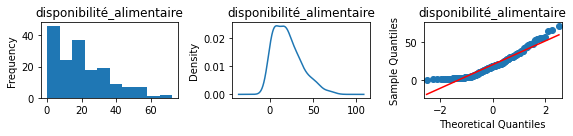

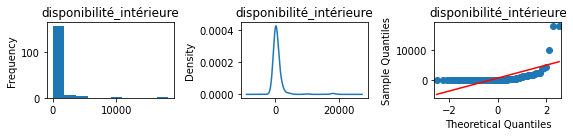

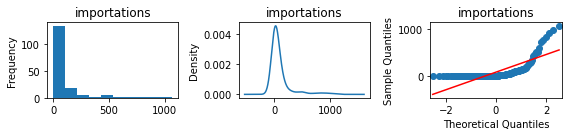

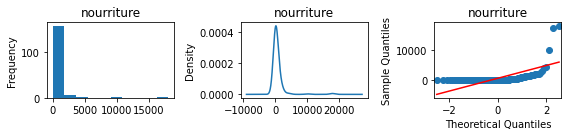

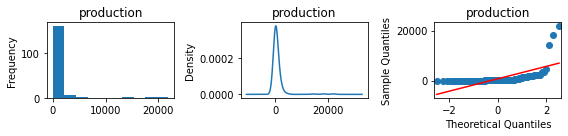

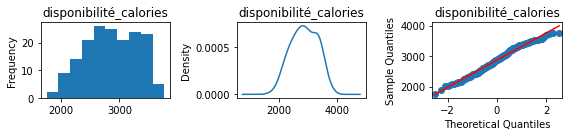

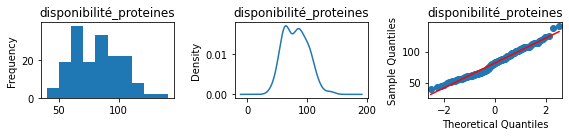

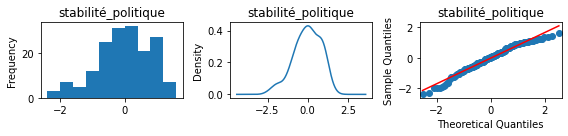

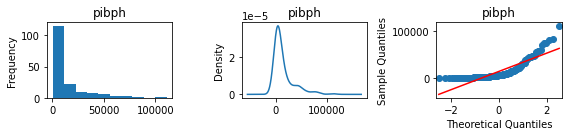

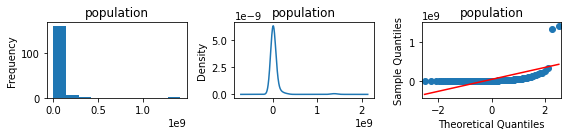

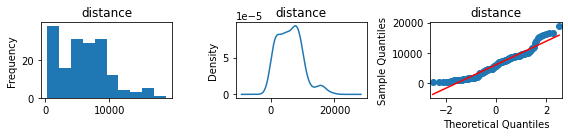

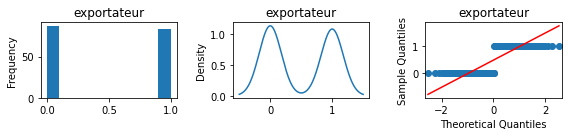

In [111]:
normality_graphical_test(data_filtered)

Statistical Test

Test de D’Agostino et Pearson (α = 0.05)

In [112]:
dagostino_test(data_filtered, 0.05)

Test de D’Agostino et Pearson (alpha = 0.05) 

Variable : disponibilité_alimentaire
Résultat : S2 + K2 = 19.2635, p-value = 0.0001
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_intérieure
Résultat : S2 + K2 = 253.3939, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations
Résultat : S2 + K2 = 141.2625, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : nourriture
Résultat : S2 + K2 = 255.023, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : production
Résultat : S2 + K2 = 255.0359, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_calories
Résultat : S2 + K2 = 13.0268, p-value = 0.0015
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_proteines
Résultat : S2 + K2 = 4.3483, p-value = 0.1137
Interprétation :

Test de Shapiro-Wilk (α = 0.05)

In [113]:
shapiro_test(data_filtered, 0.05)

Test de Shapiro-Wilk (alpha = 0.05) 

Variable : disponibilité_alimentaire
Résultat : w = 0.9259, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_intérieure
Résultat : w = 0.2985, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations
Résultat : w = 0.5145, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : nourriture
Résultat : w = 0.2906, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : production
Résultat : w = 0.2762, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_calories
Résultat : w = 0.9823, p-value = 0.0295
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_proteines
Résultat : w = 0.9805, p-value = 0.017
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : s

On voit que la majorité des variables ne suivent pas la loi normale de distribution (distribution gaussienne). Cela exige un traitement particulier lors de l'analyse multivariée, par exemple, l'utilisation du test de corrélation de Spearman au lieu de Pearson. 

## 3.2 Multivariate Analysis

Correlation Test

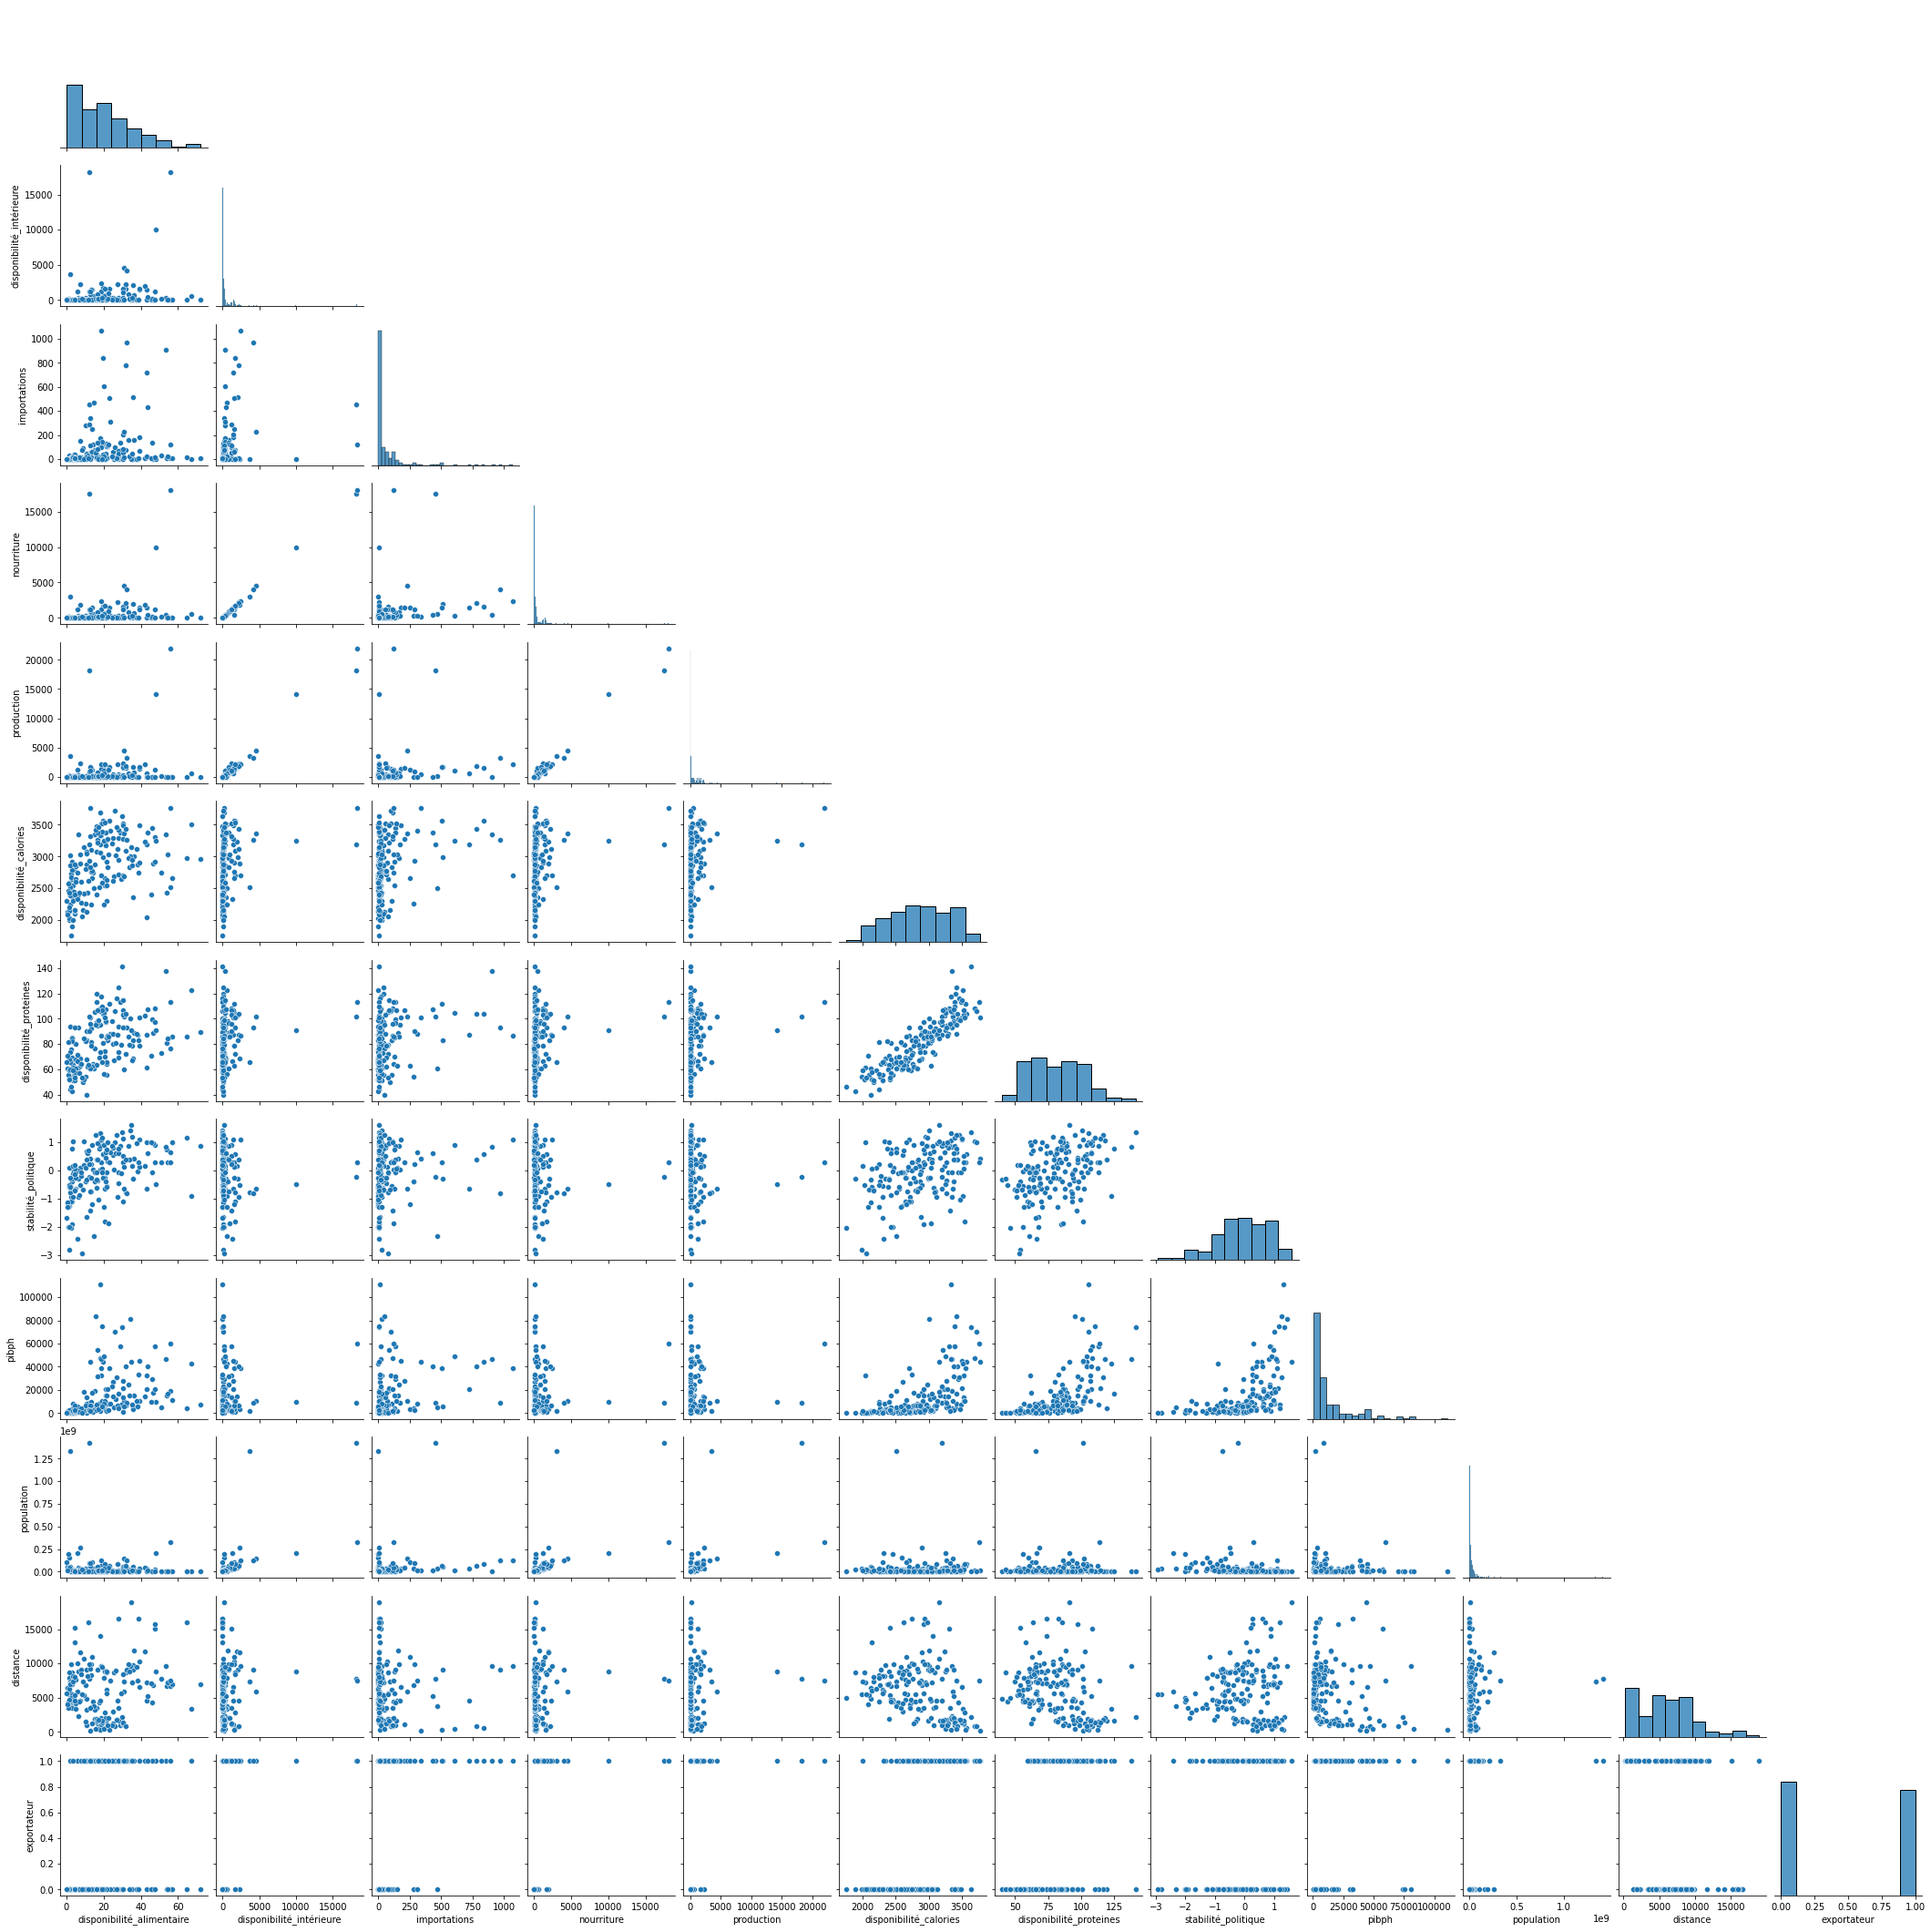

In [114]:
sns.pairplot(data=data, vars=data.columns, corner=True)
plt.show()

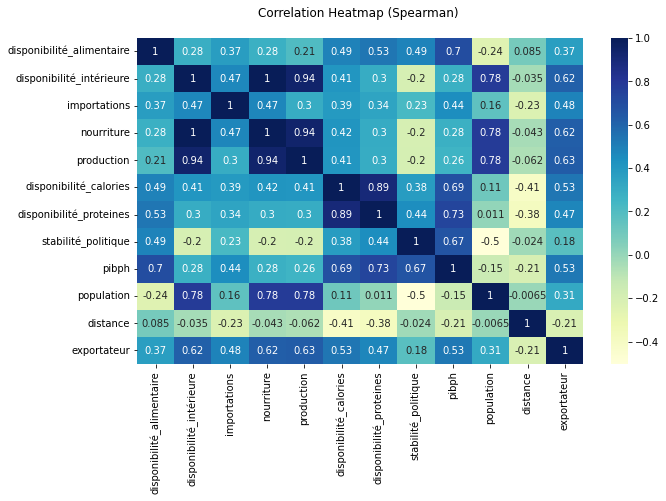

In [115]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_filtered.corr(method='spearman'), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Spearman) \n")
plt.show()

# 4 Data Selection

Observations 🔭

Il y a une corrélation très forte entre les variables : 
  - disponibilité_intérieure et nourriture (1) : Cela a beaucoup de sens puisque presque toute la viande de volailles est réservée aux consommateurs humains.
  - disponibilité_intérieure et production (0.94) : Logique, la production va augmenter le disponibilité et vice versa.
  - production et nourriture (0.94)
  - disponibilité_proteines et disponibilité_calories (0.89)

On va supprimer les variables fortement corrélées, à savoir, la disponibilité_intérieure, la nourriture et la disponibilité_protéine

In [116]:
# Supprimer les varaibles corrélées
var_supprimer = ['disponibilité_intérieure', 'nourriture', 'disponibilité_proteines']
cols = [column for column in data_filtered.columns if column not in var_supprimer]
data_clean = data_filtered[cols].copy()

In [117]:
data_clean.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
Zone,,,,,,,,,
Afrique du Sud,35.690,514,1667,2987,-0.280,6121.877,57009756,9076.306,1
Albanie,16.360,38,13,3400,0.380,4514.205,2884169,1630.739,0
Algérie,6.380,2,275,3345,-0.920,4109.696,41389189,2333.470,0
Allemagne,19.470,842,1514,3559,0.590,44651.829,82658409,613.005,1
Angola,10.560,277,42,2266,-0.380,4095.812,29816766,6862.122,0


In [118]:
data_clean.shape

(170, 9)

Puisqu'on parle d'une expansion à l'international, la France ne peut pas être un pays cible. On va donc l'enlever.

In [119]:
data_clean = data_clean[data_clean.index != 'France'].copy()

# 5 Data Transformation

On va essayer d'enlever les outliers en utilisant quelques transformations. Cela peut également normaliser la distribution de certaines variables. 

In [120]:
df = data_clean.copy()

## 5.1 Custom transformation

On commence par appliquer une transformation personnalisée. On va utiliser surtout la transformation logarithmique et la transformation racine carrée pour transformer les variables ayant des outliers et ne suivant pas la loi normal de distribution.

Voici une liste des variables affectées avec le type de transformation appliquée : 

Transformation racine carrée :
- disponibilité_alimentaire
- disponibilité_calories
- distance

Transformation logarithmique (Log10)
- production
- importations
- population
- pibph


In [121]:
df['production_t'] = np.where(df['production'] == 0, 0, np.log10(df['production']))
df['importations_t'] = np.where(df['importations'] == 0, 0, np.log10(df['importations']))
df['disponibilité_alimentaire_t'] = np.sqrt(df['disponibilité_alimentaire'])
df['disponibilité_calories_t'] = np.sqrt(df['disponibilité_calories'])
df['population_t'] = np.log10(df['population'])
df['pibph_t'] = np.log10(df['pibph'])
df['distance_t'] = np.sqrt(df['distance'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
df.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur,production_t,importations_t,disponibilité_alimentaire_t,disponibilité_calories_t,population_t,pibph_t,distance_t
Zone,,,,,,,,,,,,,,,,
Afrique du Sud,35.690,514,1667,2987,-0.280,6121.877,57009756,9076.306,1,3.222,2.711,5.974,54.653,7.756,3.787,95.270
Albanie,16.360,38,13,3400,0.380,4514.205,2884169,1630.739,0,1.114,1.580,4.045,58.310,6.460,3.655,40.382
Algérie,6.380,2,275,3345,-0.920,4109.696,41389189,2333.470,0,2.439,0.301,2.526,57.836,7.617,3.614,48.306
Allemagne,19.470,842,1514,3559,0.590,44651.829,82658409,613.005,1,3.180,2.925,4.412,59.657,7.917,4.650,24.759
Angola,10.560,277,42,2266,-0.380,4095.812,29816766,6862.122,0,1.623,2.442,3.250,47.603,7.474,3.612,82.838


In [123]:
cols = [x for x in df.columns if x.endswith('_t')]
cols.append('stabilité_politique')
cols

['production_t',
 'importations_t',
 'disponibilité_alimentaire_t',
 'disponibilité_calories_t',
 'population_t',
 'pibph_t',
 'distance_t',
 'stabilité_politique']

In [124]:
data_transformed = df[cols].copy()
data_transformed.head()

,production_t,importations_t,disponibilité_alimentaire_t,disponibilité_calories_t,population_t,pibph_t,distance_t,stabilité_politique
Zone,,,,,,,,
Afrique du Sud,3.222,2.711,5.974,54.653,7.756,3.787,95.270,-0.280
Albanie,1.114,1.580,4.045,58.310,6.460,3.655,40.382,0.380
Algérie,2.439,0.301,2.526,57.836,7.617,3.614,48.306,-0.920
Allemagne,3.180,2.925,4.412,59.657,7.917,4.650,24.759,0.590
Angola,1.623,2.442,3.250,47.603,7.474,3.612,82.838,-0.380


Allons revérifier les outliers

**Outliers Check**

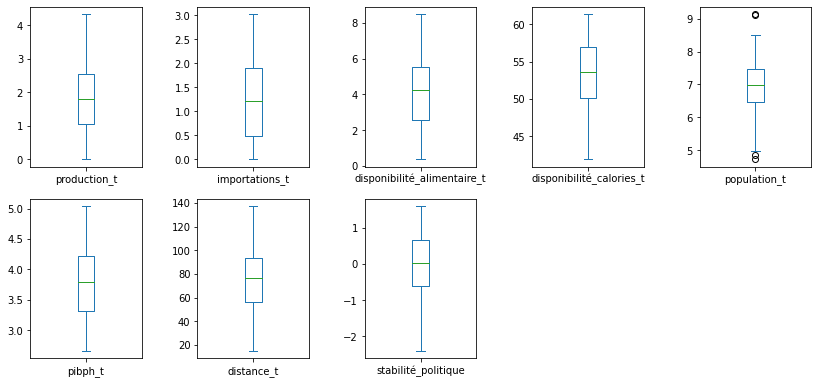

In [125]:
data_transformed.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [126]:
outliers = outliers_decector(data_transformed)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")
print(outliers['variables'])

Il y a 4 outliers au total
Il y a 1 variables ayant des outliers
['population_t']


In [127]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable population_t contient 4 outlier(s)
['Chine, continentale', 'Dominique', 'Inde', 'Saint-Kitts-et-Nevis'] 



La transformation personnalisée n'a pas réussi à enlever tous les outliers. Vérifions maintenant la distribution des variables.  

**Normality Test**

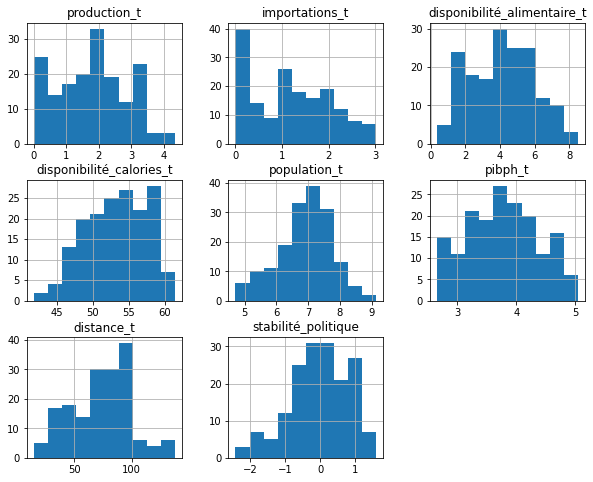

In [128]:
data_transformed.hist(figsize=(10, 8))
plt.show()

In [129]:
dagostino_test(data_transformed, 0.05)

Test de D’Agostino et Pearson (alpha = 0.05) 

Variable : production_t
Résultat : S2 + K2 = 8.3739, p-value = 0.0152
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations_t
Résultat : S2 + K2 = 24.815, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_alimentaire_t
Résultat : S2 + K2 = 9.9256, p-value = 0.007
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_calories_t
Résultat : S2 + K2 = 8.9789, p-value = 0.0112
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : population_t
Résultat : S2 + K2 = 2.4754, p-value = 0.29
Interprétation : la distribution semble normale (gaussienne) 

Variable : pibph_t
Résultat : S2 + K2 = 16.0466, p-value = 0.0003
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : distance_t
Résultat : S2 + K2 = 3.777, p-value = 0.1513
Interprétation : la distribution semble norm

In [130]:
shapiro_test(data_transformed, 0.05)

Test de Shapiro-Wilk (alpha = 0.05) 

Variable : production_t
Résultat : w = 0.9662, p-value = 0.0004
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations_t
Résultat : w = 0.9492, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_alimentaire_t
Résultat : w = 0.98, p-value = 0.0154
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_calories_t
Résultat : w = 0.9802, p-value = 0.0162
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : population_t
Résultat : w = 0.9849, p-value = 0.0637
Interprétation : la distribution semble normale (gaussienne) 

Variable : pibph_t
Résultat : w = 0.9782, p-value = 0.0091
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : distance_t
Résultat : w = 0.9756, p-value = 0.0044
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : stabilité_polit

On voit que la transformation personnalisée n'a pas non plus réussi à normaliser la distibution de certaines varialbes. On va donc essayer des autres transformations. 

## 5.2 Yeo-Johnson transform

In [131]:
df = data_clean.copy()

In [132]:
df.columns

Index(['disponibilité_alimentaire', 'importations', 'production',
       'disponibilité_calories', 'stabilité_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

In [133]:
df.describe()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
count,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000
mean,20.377,86.432,709.385,2864.077,-0.030,14122.073,42839102.710,6087.149,0.485
std,15.909,184.618,2494.257,446.295,0.847,19391.574,154409810.038,3880.271,0.501
min,0.130,0.000,0.000,1754.000,-2.410,450.901,52045.000,216.560,0.000
25%,6.460,3.000,11.000,2517.000,-0.610,2074.175,2845414.000,3210.925,0.000
50%,18.200,16.000,65.000,2872.000,0.030,6121.877,9487203.000,5871.479,0.000
75%,30.300,79.000,361.000,3250.000,0.650,16784.460,29402484.000,8665.694,1.000
max,72.310,1069.000,21914.000,3770.000,1.600,111017.182,1421021791.000,18932.170,1.000


In [134]:
X = df.values
zones = df.index
features = df.columns

In [135]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [136]:
yj = PowerTransformer(method = 'yeo-johnson')
X_trans = yj.fit_transform(X_scaled)

In [137]:
data_trans_yj = pd.DataFrame(X_trans)
data_trans_yj.columns = features
data_trans_yj.index = zones

In [138]:
data_trans_yj.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
Zone,,,,,,,,,
Afrique du Sud,1.045,1.958,1.869,0.251,-0.396,-0.219,1.439,0.845,1.030
Albanie,-0.066,0.151,-0.755,1.221,0.420,-0.473,-0.824,-1.273,-0.971
Algérie,-0.956,-0.888,0.267,1.089,-1.059,-0.541,1.095,-1.025,-0.971
Allemagne,0.163,2.018,1.820,1.603,0.711,1.616,1.761,-1.647,1.030
Angola,-0.556,1.790,-0.620,-1.324,-0.506,-0.543,0.714,0.337,-0.971


In [139]:
data_trans_yj.describe()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
count,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000
mean,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000
std,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,-1.624,-0.960,-0.817,-2.383,-2.367,-1.245,-1.056,-1.797,-0.971
25%,-0.948,-0.853,-0.764,-0.790,-0.749,-0.913,-0.827,-0.727,-0.971
50%,0.073,-0.432,-0.517,-0.010,-0.034,-0.219,-0.342,0.079,-0.971
75%,0.794,0.878,0.517,0.864,0.797,0.853,0.698,0.757,1.030
max,2.277,2.034,2.125,2.118,2.276,1.986,2.217,2.582,1.030


**Outliers Check**

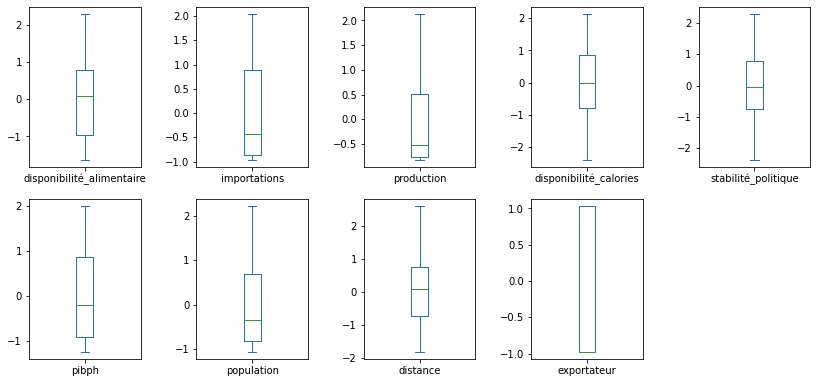

In [140]:
data_trans_yj.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [141]:
outliers = outliers_decector(data_trans_yj)
print(f"Il y a {outliers['n_outliers']} outliers au total")

Il y a 0 outliers au total


Super! On voit très bien que la transformation de Yeo-Johnson a bien enlevé tous les outliers. Allons vérifier son impact sur la distribution.

**Normality Test**

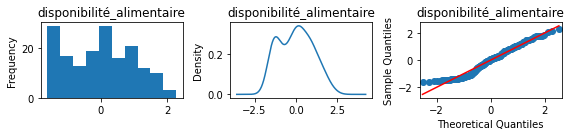

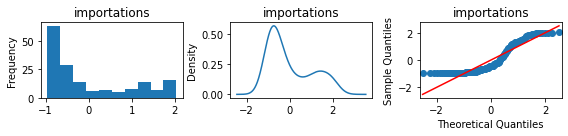

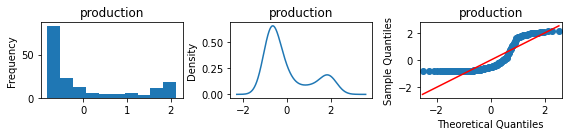

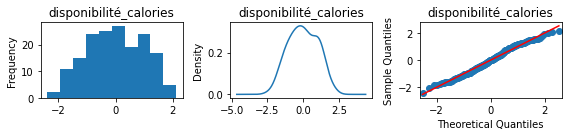

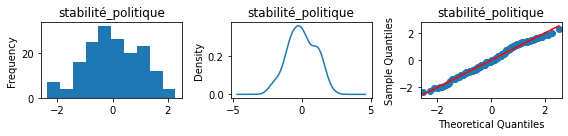

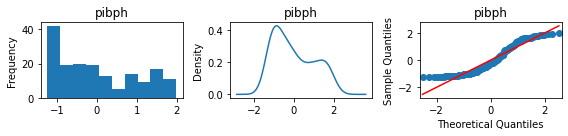

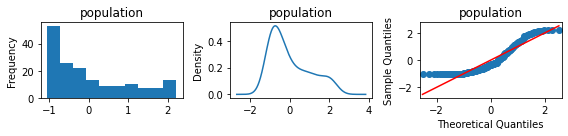

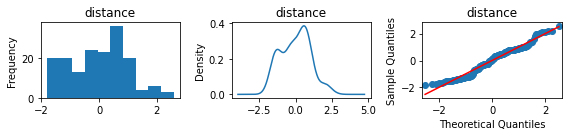

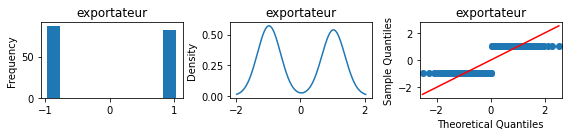

In [142]:
for col in data_trans_yj.columns:
    fig, axes = plt.subplots(1, 3, figsize = (8, 2))
    data_trans_yj[col].plot(kind='hist', ax = axes[0]);
    data_trans_yj[col].plot(kind='kde', ax = axes[1]);
    axes[0].set_title(col)
    axes[1].set_title(col)
    
    qqplot(data_trans_yj[col], line='s', ax = axes[2])
    plt.title(col)
    fig.tight_layout()
    plt.show()

In [143]:
dagostino_test(data_trans_yj, 0.05)

Test de D’Agostino et Pearson (alpha = 0.05) 

Variable : disponibilité_alimentaire
Résultat : S2 + K2 = 25.134, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations
Résultat : S2 + K2 = 31.6192, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : production
Résultat : S2 + K2 = 26.5579, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : disponibilité_calories
Résultat : S2 + K2 = 13.5022, p-value = 0.0012
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : stabilité_politique
Résultat : S2 + K2 = 5.0543, p-value = 0.0799
Interprétation : la distribution semble normale (gaussienne) 

Variable : pibph
Résultat : S2 + K2 = 58.0879, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : population
Résultat : S2 + K2 = 20.3688, p-value = 0.0
Interprétation : la distribution semble anormale (n

On aperçoit que la transformation de Yeo-Johnson n'a pas réussi à normaliser la distribution des variables anormales. Donc, on va essayer une derinère transformation, Celle de Box-Cox. 

## 5.3 Box-Cox trasform

In [144]:
df = data_clean.copy()

In [145]:
df.columns

Index(['disponibilité_alimentaire', 'importations', 'production',
       'disponibilité_calories', 'stabilité_politique', 'pibph', 'population',
       'distance', 'exportateur'],
      dtype='object')

In [146]:
df.describe()

,disponibilité_alimentaire,importations,production,disponibilité_calories,stabilité_politique,pibph,population,distance,exportateur
count,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000,169.000
mean,20.377,86.432,709.385,2864.077,-0.030,14122.073,42839102.710,6087.149,0.485
std,15.909,184.618,2494.257,446.295,0.847,19391.574,154409810.038,3880.271,0.501
min,0.130,0.000,0.000,1754.000,-2.410,450.901,52045.000,216.560,0.000
25%,6.460,3.000,11.000,2517.000,-0.610,2074.175,2845414.000,3210.925,0.000
50%,18.200,16.000,65.000,2872.000,0.030,6121.877,9487203.000,5871.479,0.000
75%,30.300,79.000,361.000,3250.000,0.650,16784.460,29402484.000,8665.694,1.000
max,72.310,1069.000,21914.000,3770.000,1.600,111017.182,1421021791.000,18932.170,1.000


In [147]:
max = df['stabilité_politique'].max()
min = df['stabilité_politique'].min()
df['stabilité_politique_t'] = (df['stabilité_politique'] - min) / (max - min)

In [148]:
df.drop(columns=['stabilité_politique'], inplace=True)

In [149]:
# Remplacer les 0 par 0,000001 car box-cox n'accepte pas des 0
df.replace(0, 0.000001, inplace=True)

In [150]:
df.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,pibph,population,distance,exportateur,stabilité_politique_t
Zone,,,,,,,,,
Afrique du Sud,35.690,514.000,1667.000,2987,6121.877,57009756,9076.306,1.000,0.531
Albanie,16.360,38.000,13.000,3400,4514.205,2884169,1630.739,0.000,0.696
Algérie,6.380,2.000,275.000,3345,4109.696,41389189,2333.470,0.000,0.372
Allemagne,19.470,842.000,1514.000,3559,44651.829,82658409,613.005,1.000,0.748
Angola,10.560,277.000,42.000,2266,4095.812,29816766,6862.122,0.000,0.506


In [151]:
X = df.values
zones = df.index
features = df.columns

In [152]:
bc = PowerTransformer(method = 'box-cox')
bc.fit(X)
X_trans = bc.transform(X)

In [153]:
data_trans_bc = pd.DataFrame(X_trans)
data_trans_bc.columns = features
data_trans_bc.index = zones

In [154]:
data_trans_bc.head()

,disponibilité_alimentaire,importations,production,disponibilité_calories,pibph,population,distance,exportateur,stabilité_politique_t
Zone,,,,,,,,,
Afrique du Sud,0.995,1.696,1.310,0.263,0.023,1.031,0.829,1.030,-0.312
Albanie,0.012,0.362,-0.515,1.214,-0.200,-0.554,-1.257,-0.971,0.480
Algérie,-0.834,-0.590,0.485,1.086,-0.268,0.850,-0.957,-0.971,-1.065
Allemagne,0.206,2.021,1.260,1.586,1.448,1.245,-1.846,1.030,0.735
Angola,-0.420,1.325,-0.180,-1.334,-0.271,0.667,0.355,-0.971,-0.431


**Outliers Check**

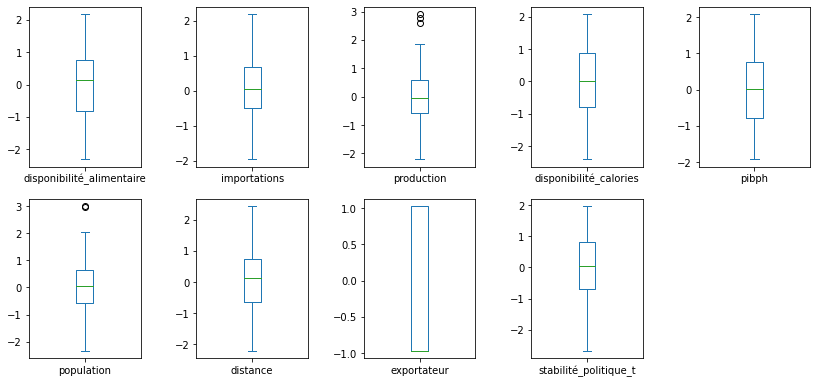

In [155]:
data_trans_bc.plot(kind='box', subplots=True, layout=(3, 5), figsize=(14, 10))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [156]:
outliers = outliers_decector(data_trans_bc)
print(f"Il y a {outliers['n_outliers']} outliers au total")
print(f"Il y a {outliers['n_variables']} variables ayant des outliers")
print(outliers['variables'])

Il y a 4 outliers au total
Il y a 2 variables ayant des outliers
['production', 'population']


In [157]:
for outlier in outliers['list']:
  print(f"La variable {outlier['var_name']} contient {outlier['n_outliers']} outlier(s)")
  print(outlier['outliers'], '\n')

La variable production contient 3 outlier(s)
['Brésil', 'Chine, continentale', "États-Unis d'Amérique"] 

La variable population contient 2 outlier(s)
['Chine, continentale', 'Inde'] 



Le resultat de la transformation de Box-Cox est moins intéressant de celle de Yeo-johnson en ce qui cencerne les outliers. Effictivement, elle a laissé quelques outliers. Vérifions si elle a fait un bon travail pour normaliser la distribution des variables.  

**Normality Test**

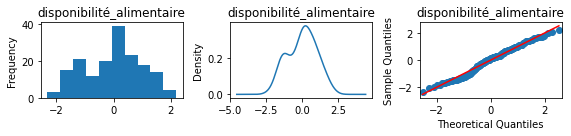

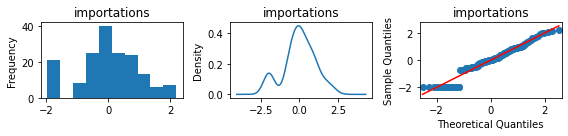

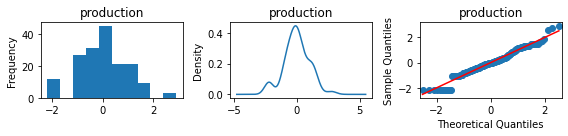

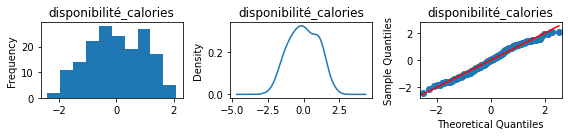

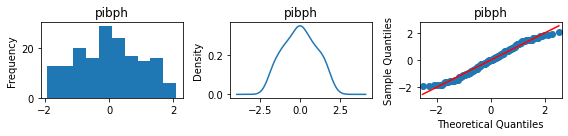

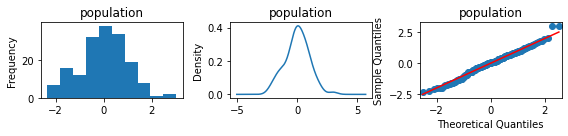

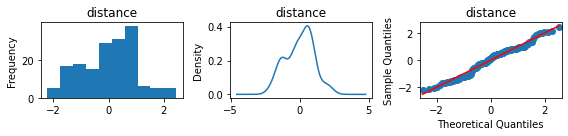

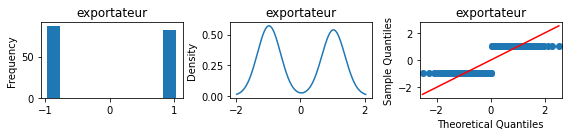

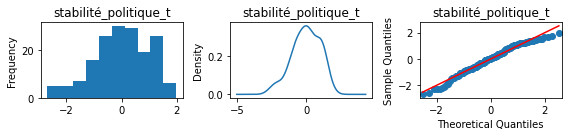

In [158]:
normality_graphical_test(data_trans_bc)

In [159]:
dagostino_test(data_trans_bc, 0.05)

Test de D’Agostino et Pearson (alpha = 0.05) 

Variable : disponibilité_alimentaire
Résultat : S2 + K2 = 10.5753, p-value = 0.0051
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : importations
Résultat : S2 + K2 = 2.9783, p-value = 0.2256
Interprétation : la distribution semble normale (gaussienne) 

Variable : production
Résultat : S2 + K2 = 1.9475, p-value = 0.3777
Interprétation : la distribution semble normale (gaussienne) 

Variable : disponibilité_calories
Résultat : S2 + K2 = 13.5464, p-value = 0.0011
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : pibph
Résultat : S2 + K2 = 16.1945, p-value = 0.0003
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : population
Résultat : S2 + K2 = 0.3451, p-value = 0.8415
Interprétation : la distribution semble normale (gaussienne) 

Variable : distance
Résultat : S2 + K2 = 3.6859, p-value = 0.1583
Interprétation : la distribution semble normale (gaussienne

Alors que la transformation de Box-Cox a effictivement réussi à normaliser certaines variables, elle a laissé quelques outliers. Le fait que l'existence des outliers a un impact plus grave sur les algorithmes de clustering et de classification que l'on va mise en oeurvre dans la deuxième partie, on préfère toujours avoir un jeu de données sans outliers. On va donc retenir la transoformation de Yeo-Johnson pour la deuxième partie.

# 6 Data Export

In [160]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data.csv')
data_clean.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_clean.csv')
data_transformed.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_transformed.csv')
data_trans_bc.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_trans_bc.csv')
data_trans_yj.to_csv('/content/drive/MyDrive/Colab Notebooks/OC-DAN/P9/p9_data_trans_yj.csv')